In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Flatten, Reshape, BatchNormalization,
                                     LeakyReLU, Concatenate, Conv2DTranspose, Conv2D,
                                     Dropout, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# ---------------- Fashion-MNIST Data ----------------
fashion_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
                  "Sandal","Shirt","Sneaker","Bag","Ankle boot"]
num_classes = 10

(x_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, -1)
y_train_oh = to_categorical(y_train, num_classes)
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 128
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_oh)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# ---------------- Model Parameters ----------------
noise_dim = 100
EPOCHS = 10
diffusion_steps = 100
lambda_diff = 0.3  # weight for diffusion loss

# ---------------- Generator with Residual ----------------
def build_generator():
    noise_input = Input(shape=(noise_dim,))
    label_input = Input(shape=(num_classes,))
    model_input = Concatenate()([noise_input, label_input])

    # Dense feature expansion
    x = Dense(7 * 7 * 512, use_bias=False)(model_input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Reshape to feature map
    x = Reshape((7, 7, 512))(x)

    # Conv transpose 1
    x1 = Conv2DTranspose(256, (5,5), strides=(1,1), padding="same", use_bias=False)(x)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU()(x1)

    # Conv transpose 2
    x2 = Conv2DTranspose(128, (5,5), strides=(2,2), padding="same", use_bias=False)(x1)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU()(x2)

    # Residual connection
    x_res = Conv2DTranspose(128, (3,3), strides=(1,1), padding="same", use_bias=False)(x2)
    x2 = Add()([x2, x_res])
    x2 = LeakyReLU()(x2)

    # Conv transpose 3
    x3 = Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False)(x2)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU()(x3)

    # Additional layer
    x4 = Conv2DTranspose(32, (3,3), strides=(1,1), padding="same", use_bias=False)(x3)
    x4 = BatchNormalization()(x4)
    x4 = LeakyReLU()(x4)

    img_output = Conv2DTranspose(1, (5,5), strides=(1,1), padding="same", use_bias=False, activation="tanh")(x4)
    return Model([noise_input, label_input], img_output, name="Generator")

# ---------------- Discriminator (without Spectral Norm) ----------------
def build_discriminator():
    img_input = Input(shape=(28, 28, 1))
    label_input = Input(shape=(num_classes,))

    label_map = Dense(28*28)(label_input)
    label_map = Reshape((28, 28, 1))(label_map)
    combined = Concatenate()([img_input, label_map])

    x = Conv2D(64, (5,5), strides=(2,2), padding="same")(combined)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (5,5), strides=(2,2), padding="same")(x)
    x = LeakyReLU()(x)
    x = Dropout(0.4)(x)

    x = Conv2D(256, (5,5), strides=(2,2), padding="same")(x)
    x = LeakyReLU()(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    return Model([img_input, label_input], x, name="Discriminator")

# ---------------- Diffusion Helpers ----------------
def get_diffusion_schedule(T):
    beta_start, beta_end = 1e-4, 0.02
    betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas)
    return betas, alphas, alphas_cumprod

betas, alphas, alphas_cumprod = get_diffusion_schedule(diffusion_steps)

def q_sample(x_start, t, noise):
    sqrt_alphas_cumprod_t = tf.gather(tf.sqrt(alphas_cumprod), t)
    sqrt_one_minus = tf.gather(tf.sqrt(1 - alphas_cumprod), t)
    return sqrt_alphas_cumprod_t[:, None, None, None] * x_start + sqrt_one_minus[:, None, None, None] * noise

# ---------------- Build Models ----------------
generator = build_generator()
discriminator = build_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_opt = Adam(2e-4, 0.5)
disc_opt = Adam(2e-4, 0.5)

# ---------------- Training Step ----------------
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([tf.shape(images)[0], noise_dim])
    t = tf.random.uniform([tf.shape(images)[0]], 0, diffusion_steps, dtype=tf.int32)
    eps = tf.random.normal(tf.shape(images))

    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        generated = generator([noise, labels], training=True)

        # Diffusion forward
        x_t = q_sample(generated, t, eps)

        # Predict noise (reuse generator)
        eps_pred = generator([tf.random.normal([tf.shape(images)[0], noise_dim]), labels], training=True)
        eps_pred = tf.image.resize(eps_pred, [28,28])
        diff_loss = tf.reduce_mean(tf.square(eps - eps_pred))

        # GAN outputs
        real_out = discriminator([images, labels], training=True)
        fake_out = discriminator([generated, labels], training=True)

        # Label smoothing: real=0.9, fake=0.1
        gen_loss_gan = cross_entropy(tf.ones_like(fake_out)*0.9, fake_out)
        disc_loss_real = cross_entropy(tf.ones_like(real_out)*0.9, real_out)
        disc_loss_fake = cross_entropy(tf.zeros_like(fake_out)+0.1, fake_out)
        disc_loss = disc_loss_real + disc_loss_fake

        gen_loss = gen_loss_gan + lambda_diff * diff_loss

    # Gradients
    grad_gen = tape.gradient(gen_loss, generator.trainable_variables)
    grad_disc = tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    gen_opt.apply_gradients(zip(grad_gen, generator.trainable_variables))
    disc_opt.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

    del tape
    return gen_loss, disc_loss, diff_loss

# ---------------- Training Loop ----------------
gen_losses, disc_losses, diff_losses = [], [], []

def train(dataset, epochs):
    for epoch in range(1, epochs+1):
        g_l, d_l, diff_l = [], [], []
        for images, labels in dataset:
            # Train generator twice per discriminator step
            gl1, dl, dfl = train_step(images, labels)
            gl2, _, _ = train_step(images, labels)
            g_l.append((gl1.numpy()+gl2.numpy())/2)
            d_l.append(dl.numpy())
            diff_l.append(dfl.numpy())
        gen_losses.append(np.mean(g_l))
        disc_losses.append(np.mean(d_l))
        diff_losses.append(np.mean(diff_l))
        print(f"Epoch {epoch}/{epochs} | Gen: {gen_losses[-1]:.4f} | Disc: {disc_losses[-1]:.4f} | Diff: {diff_losses[-1]:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.plot(diff_losses, label="Diffusion Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.show()


# ---------------- Generate & Show ----------------
def generate_and_show_images(model, label, num_examples=16):
    noise = tf.random.normal([num_examples, noise_dim])
    label_vec = tf.constant(np.eye(num_classes)[[label]*num_examples], dtype=tf.float32)
    preds = model([noise, label_vec], training=False)
    preds = (preds + 1) / 2.0
    fig = plt.figure(figsize=(4,4))
    for i in range(num_examples):
        plt.subplot(4,4,i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Category: {fashion_labels[label]}")
    plt.show()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Epoch 1/10 | Gen: 1.2781 | Disc: 1.3252 | Diff: 1.6787
Epoch 2/10 | Gen: 1.2898 | Disc: 1.3177 | Diff: 1.6746
Epoch 3/10 | Gen: 1.2992 | Disc: 1.3119 | Diff: 1.6773
Epoch 4/10 | Gen: 1.2998 | Disc: 1.3116 | Diff: 1.6736
Epoch 5/10 | Gen: 1.3141 | Disc: 1.3035 | Diff: 1.6758
Epoch 6/10 | Gen: 1.3156 | Disc: 1.3015 | Diff: 1.6722
Epoch 7/10 | Gen: 1.3242 | Disc: 1.2970 | Diff: 1.6784
Epoch 8/10 | Gen: 1.3313 | Disc: 1.2925 | Diff: 1.6742
Epoch 9/10 | Gen: 1.3460 | Disc: 1.2841 | Diff: 1.6784
Epoch 10/10 | Gen: 1.3529 | Disc: 1.2777 | Diff: 1.6757


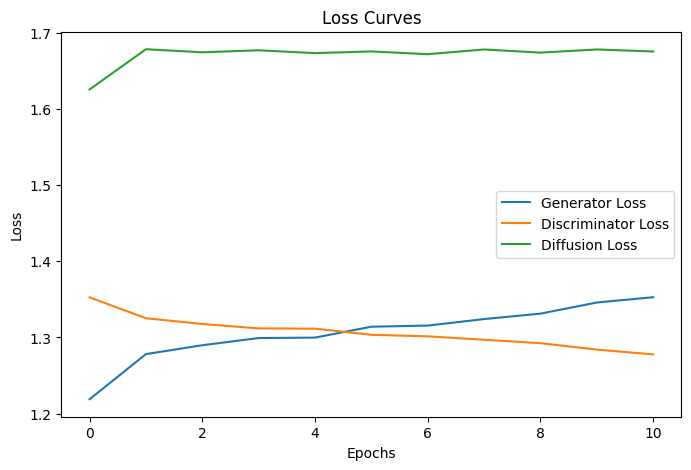

In [ ]:
train(dataset, EPOCHS)

In [ ]:
# ---------------- Save the Trained Models ----------------
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")

print("✅ Models saved successfully as 'generator_model.h5' and 'discriminator_model.h5'")


✅ Models saved successfully as 'generator_model.h5' and 'discriminator_model.h5'


Available Fashion-MNIST categories:
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot
Enter category index (0-9) for which to generate images: 2
Chosen category: Pullover


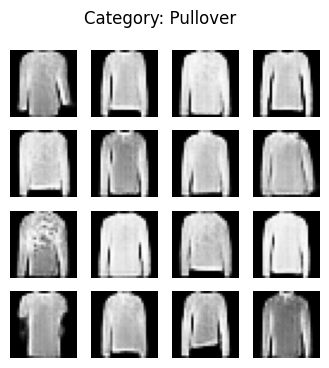

In [ ]:
# Pick category and generate images
print("Available Fashion-MNIST categories:")
for idx, name in enumerate(fashion_labels):
    print(f"{idx}: {name}")
chosen_label = int(input("Enter category index (0-9) for which to generate images: "))
print("Chosen category:", fashion_labels[chosen_label])

generate_and_show_images(generator,chosen_label)